# Creación de un modelo que extiende un fragmento de notas MIDI

En este notebook definimos y entrenamos un modelo que, a partir de una secuencia de notas MIDI, genera nuevas notas que la continúan. Antes de definir el modelo haremos el preprocesamiento de los datos.

A lo largo del notebook usaremos las funciones de las clases MelodIA y Utilities definidas en el módulo model.py.

In [ ]:
import pandas as pd
import numpy as np
import pretty_midi
import tensorflow as tf

from model import MelodIAModel, Utilities

## Exploración inicial

Como conjunto de datos hemos elegido el dataset [MAESTRO](https://magenta.tensorflow.org/datasets/maestro) (MIDI and Audio Edited for Synchronous TRacks and Organization).

Este dataset incluye una separación en conjuntos de train. validation y test, lo que nos facilitará el procesado. Una vez lo hemos descargado en local, cargamos el csv que contiene:

In [ ]:
df = pd.read_csv("data/maestro-v3.0.0/maestro-v3.0.0.csv")
df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508
...,...,...,...,...,...,...,...
1271,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",test,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,241.470442
1272,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,114.696243
1273,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",validation,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,1139.198478
1274,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",validation,2018,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,1068.751602


Seleccionando como ejemplo la primera fila, podemos ver la ruta al archivo MIDI correspondiente.

In [ ]:
sample_file_path = "data/maestro-v3.0.0/" + df.loc[0]["midi_filename"]
sample_file_path

'../maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi'

Usaremos la librería PrettyMIDI para manejar los archivos MIDI.

In [4]:
pm = pretty_midi.PrettyMIDI(sample_file_path)

Con el siguiente código podemos ver el número de instrumentos y su nombre para un objeto PrettyMIDI.

In [5]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Iterando sobre las notas del MIDI podemos ver las siguientes características de cada una:
- __pitch__: número de nota MIDI

- __note_name__: nombre musical de la nota.

- __duration__: duración de la nota en segundos, calculada como end - start

- __start__: momento en el que la nota comienza a sonar, medido en segundos desde el inicio de la pieza

- __end__: momento en el que la nota deja de sonar, también en segundos desde el inicio

- __velocity__: intensidad o fuerza con la que se tocó la nota

In [8]:
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    onset = note.start
    offset = note.end
    velocity = note.velocity
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, '
          f'duration={duration:.4f}, start={onset:.4f}, end={offset:.4f} velocity={velocity}')

0: pitch=67, note_name=G4, duration=0.8268, start=0.9831, end=1.8099 velocity=52
1: pitch=72, note_name=C5, duration=0.1224, start=1.7839, end=1.9062 velocity=67
2: pitch=67, note_name=G4, duration=0.9792, start=2.1810, end=3.1602 velocity=39
3: pitch=61, note_name=C#4, duration=1.0651, start=2.1784, end=3.2435 velocity=39
4: pitch=78, note_name=F#5, duration=1.4531, start=2.1471, end=3.6003 velocity=65
5: pitch=71, note_name=B4, duration=2.1706, start=2.1536, end=4.3242 velocity=45
6: pitch=79, note_name=G5, duration=0.3203, start=4.0990, end=4.4193 velocity=58
7: pitch=79, note_name=G5, duration=0.3893, start=4.7448, end=5.1341 velocity=69
8: pitch=70, note_name=A#4, duration=0.4831, start=4.7643, end=5.2474 velocity=64
9: pitch=75, note_name=D#5, duration=0.0820, start=5.2057, end=5.2878 velocity=70


Vamos a obtener una nueva característica a partir de las ya existentes que proporciona PrettyMIDI. Se trata del __step__, calculado como el tiempo desde el start de la nota anterior hasta el start de la nota actual.

Visualizamos todas las características en un dataframe:

In [6]:
raw_notes = Utilities.midi_path_to_df(sample_file_path)
raw_notes.head()

,name,pitch,start,end,step,duration,velocity
0,G4,67,0.983073,1.809896,0.000000,0.826823,52
1,C5,72,1.783854,1.906250,0.800781,0.122396,67
2,F#5,78,2.147135,3.600260,0.363281,1.453125,65
3,B4,71,2.153646,4.324219,0.006510,2.170573,45
4,C#4,61,2.178385,3.243490,0.024740,1.065104,39


Al obtener un dataframe podemos visualizar fácilmente como se distribuyen las diferentes características.

In [11]:
raw_notes.describe()

,pitch,start,end,step,duration,velocity
count,4197.000000,4197.000000,4197.000000,4197.000000,4197.000000,4197.000000
mean,65.149392,333.700239,334.097744,0.162380,0.397505,64.896593
std,13.047352,182.530640,182.562796,0.268729,0.646380,19.101500
min,27.000000,0.983073,1.809896,0.000000,0.001302,2.000000
25%,57.000000,184.661458,184.729167,0.007812,0.078125,50.000000
50%,65.000000,352.662760,353.243490,0.044271,0.209635,66.000000
75%,75.000000,498.846354,498.889323,0.226562,0.481771,81.000000
max,102.000000,682.492188,698.661458,4.803385,21.013021,111.000000


También podemos visualizar el archivo MIDI como un "piano roll".

/home/carmenfdez/MUS/melodIA/model/model.py:151: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


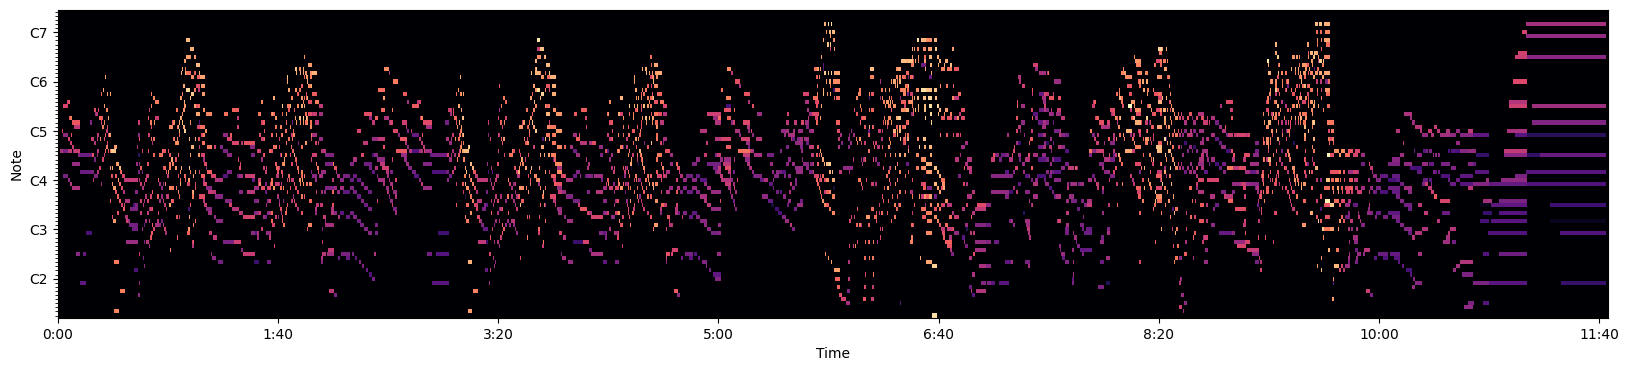

In [12]:
Utilities.plot_piano_roll(pm, 27, 102)

### Características de las notas que vamos a tener en cuenta para entrenar el modelo:
- pitch
- step
- duration
- velocity

No usaremos __start__ ni __end__ ya que se pueden inferir con step y duration y por tanto pueden resultar redundantes. Intentaremos usar el menor número de variables posibles para no aumentar demasiado la complejidad del modelo, que se traduciría en mayor tiempo de ejecución.

En la siguiente visualización podemos observar las distribuciones de las cuatro características elegidas. Como se puede ver __step__ y __duration__ varían dentro de un rango de valores pequeño en comparación con los rangos de __pitch__ y __velocity__. Por esta razón hemos decidido __normalizar__ estas dos últimas variables para que no afecten al modelo. Tras la noramlización ambas variables tendrán valores en el rango 0-1.

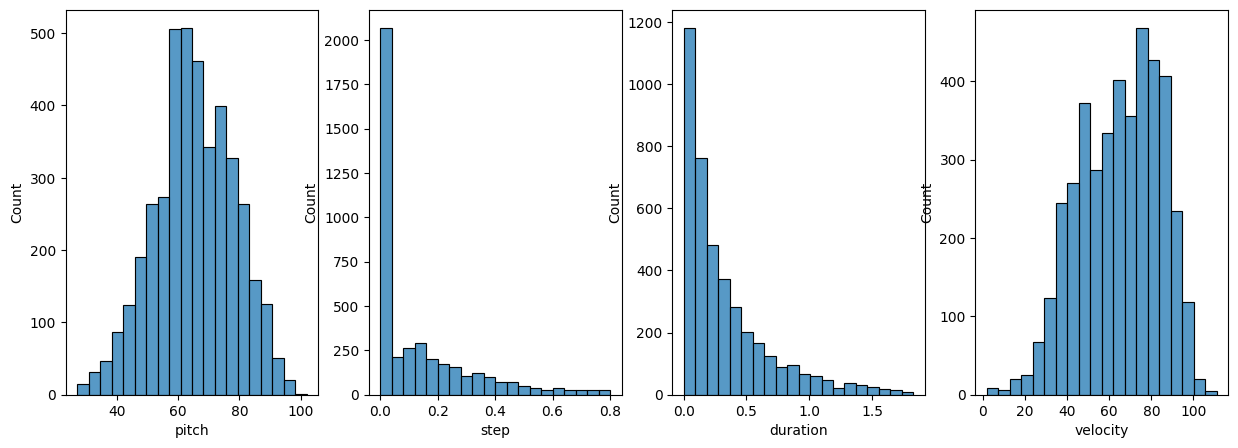

In [7]:
Utilities.plot_df_distributions(raw_notes)

## Preprocesado de los datos

En primer lugar vamos a dividir el conjunto de datos en los conjuntos de train, validation y test que ya vienen predefinidos en la columna "split".

In [8]:
df_train = df[df["split"] == "train"]
df_val = df[df["split"] == "validation"]
df_test = df[df["split"] == "test"]

Tras obtener varios errores (kernel killed) debido al gran tamaño de los datos decidimos utilizar muestras aleatorias correspondientes a la mitad de cada conjunto. Esto nos evitó errores posteriores.

In [9]:
RANDOM_STATE = 13

In [10]:
# Para df_train
df_train = df_train.sample(frac=0.5, random_state=RANDOM_STATE)

# Para df_val
df_val = df_val.sample(frac=0.5, random_state=RANDOM_STATE)

# Para df_test
df_test = df_test.sample(frac=0.5, random_state=RANDOM_STATE)

Tamaños finales de los conjuntos. El primer número de cada shape indica la cantidad de archivos midi en cada conjunto.

In [11]:
df_train.shape, df_val.shape, df_test.shape

((481, 7), (68, 7), (88, 7))

### Conversión de los archivos MIDI en arrays

Obtener los arrays de notas para un conjunto de datos (train/val/test).

In [ ]:
# Conjunto de entrenamiento
train_notes = Utilities.df_to_notes(df_train)

In [ ]:
# Conjunto de validación
val_notes = Utilities.df_to_notes(df_val)

In [ ]:
# Conjunto de test
test_notes = Utilities.df_to_notes(df_test)

En la siguiente salida vemos la forma del array de notas correspondientes al conjunto de validación.

Se trata de una lista que contiene un array por cada archivo MIDI. A su vez, cada array de un archivo MIDI contiene un array con todas sus notas. Cada nota está formada por un array de 4 elementos, que corresponden a los valores de pitch, step, duration y velocity.

Utilizamos esta forma de almacenar los datos ya que tensorflow admite tensores como input (arrays de NumPy).

In [ ]:
val_notes # (num_canciones, num_notas, 4)

[array([[ 6.20000000e+01,  0.00000000e+00,  8.72395833e-02,
          3.00000000e+01],
        [ 5.20000000e+01, -5.20833333e-03,  1.17187500e-01,
          3.30000000e+01],
        [ 5.80000000e+01,  2.34375000e-02,  1.15885417e-01,
          3.50000000e+01],
        ...,
        [ 9.80000000e+01, -3.90625000e-03,  4.42708333e-02,
          9.60000000e+01],
        [ 9.30000000e+01, -1.30208333e-03,  4.68750000e-02,
          1.09000000e+02],
        [ 1.05000000e+02, -2.60416667e-03,  5.85937500e-02,
          1.16000000e+02]]),
 array([[ 7.30000000e+01,  0.00000000e+00,  2.36979167e-01,
          3.50000000e+01],
        [ 7.40000000e+01,  6.66666667e-01,  4.21875000e-01,
          4.50000000e+01],
        [ 7.30000000e+01,  3.50260417e-01,  2.56510417e-01,
          5.70000000e+01],
        ...,
        [ 6.40000000e+01, -2.34375000e-02,  2.79036458e+00,
          3.70000000e+01],
        [ 6.80000000e+01, -3.90625000e-02,  2.82942708e+00,
          3.40000000e+01],
        [ 7.300

Almacenar los arrays en memoria (para poder reusarlos más adelante)

In [50]:
OUTPUT_PATH = "data/"
train_filename = "train_notes_processed.npz"
val_filename = "val_notes_processed.npz"
test_filename = "test_notes_processed.npz"

In [15]:
np.savez_compressed(OUTPUT_PATH + train_filename, *train_notes)
print(f"Arrays de notas guardados en {OUTPUT_PATH + train_filename}")

Arrays de notas guardados en data/train_notes_processed.npz


In [25]:
np.savez_compressed(OUTPUT_PATH + val_filename, *val_notes)
print(f"Arrays de notas guardados en {OUTPUT_PATH + val_filename}")

Arrays de notas guardados en data/val_notes_processed.npz


In [51]:
np.savez_compressed(OUTPUT_PATH + test_filename, *test_notes)
print(f"Arrays de notas guardados en {OUTPUT_PATH + test_filename}")

Arrays de notas guardados en data/test_notes_processed.npz


Cargar los arrays de memoria

In [ ]:
train_notes = Utilities.load_processed_notes(OUTPUT_PATH + train_filename)

Cargando arrays de notas desde data/train_notes_processed.npz...
Cargados 481 arrays.


In [ ]:
val_notes = Utilities.load_processed_notes(OUTPUT_PATH + val_filename)

Cargando arrays de notas desde data/val_notes_processed.npz...
Cargados 68 arrays.


In [ ]:
test_notes = Utilities.load_processed_notes(OUTPUT_PATH + test_filename)

### Creación de secuencias

Para introducir las notas en el modelo las transformamos en secuencias. De esta manera una secuencia se utilizará como un ejemplo de entrenamiento, cuyo target es la nota inmediatamente siguiente a la secuencia.

Creamos las secuencias "a mano":
 - secuencia: 25 notas
 - etiqueta: 1 nota (la inmediatamente siguiente)

In [ ]:
# Conjunto de entrenamiento
secuencias_train, etiquetas_train = MelodIAModel.crear_secuencias(train_notes)

In [ ]:
# Conjunto de validación
secuencias_val, etiquetas_val = MelodIAModel.crear_secuencias(val_notes)

In [ ]:
# Conjunto de test
secuencias_test, etiquetas_test = MelodIAModel.crear_secuencias(test_notes)

### Creación de Datasets de Tensorflow

El input del modelo será un Dataset de Tensorflow creado a partir de las secuencias y etiquetas generadas en el paso anterior.

Utilizamos un batch_size de 64. Esto significa que el proceso de entrenamiento no actualizará los pesos del modelo después de procesar cada ejemplo individual del conjunto de entrenamiento. En cambio, lo hará después de procesar un grupo de 64 ejemplos a la vez. Esto nos ayudará a reducir el tiempo de entrenamiento.

In [57]:
BATCH_SIZE = 64

- Dataset de entrenamiento.

Como este conjunto es el más grande utilizamos una función diferente para crear el Dataset. Esta función utiliza un __generador__. Cuando después se itere sobre train_dataset durante el entrenamiento (con model.fit(train_dataset)), TensorFlow llamará al generador (data_generator) repetidamente para obtener los siguientes batches de datos. De manera que solo se cargan en memoria los batches de datos que se necesitan para cada paso del entrenamiento, en lugar de cargar todo el conjunto de datos de entrenamiento al principio.

In [ ]:
train_dataset = MelodIAModel.crear_train_dataset_tensorflow(secuencias_train, etiquetas_train, BATCH_SIZE)

In [ ]:
# Lo guardamos
tf.data.Dataset.save(train_dataset, "data/train_dataset")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


- Dataset de validación.

In [ ]:
val_dataset = MelodIAModel.crear_dataset_tensorflow(secuencias_val, etiquetas_val, BATCH_SIZE)

I0000 00:00:1747153928.440542   15484 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:02:00.0, compute capability: 8.6


In [ ]:
# Lo guardamos
tf.data.Dataset.save(val_dataset, "data/val_dataset")

- Dataset de prueba (test).

In [ ]:
test_dataset = MelodIAModel.crear_dataset_tensorflow(secuencias_test, etiquetas_test, BATCH_SIZE)

Cargar un dataset anteriormente guardado

In [ ]:
val_dataset = tf.data.Dataset.load("data/val_dataset")

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


En la siguiente salida podemos ver cómo es un batch, tanto la secuencia de notas como su correspondiente etiqueta.

In [ ]:
for batch in train_dataset.take(1):
    secuencias_batch, etiquetas_batch = batch
    print("Batch de secuencias:")
    print(secuencias_batch.numpy())
    print("Batch de etiquetas:")
    print(etiquetas_batch)

Batch de secuencias:
[[[ 0.5826772   0.          0.03541667  0.65873015]
  [ 0.52755904  0.009375    0.028125    0.5952381 ]
  [ 0.5590551   0.00208333  0.028125    0.5793651 ]
  ...
  [ 0.51968503  0.00104167  0.02916667  0.63492066]
  [ 0.48818898  0.00104167  0.03854167  0.54761904]
  [ 0.61417323 -0.00520833  0.05625     0.6825397 ]]

 [[ 0.52755904  0.009375    0.028125    0.5952381 ]
  [ 0.5590551   0.00208333  0.028125    0.5793651 ]
  [ 0.5826772   0.425       0.034375    0.52380955]
  ...
  [ 0.48818898  0.00104167  0.03854167  0.54761904]
  [ 0.61417323 -0.00520833  0.05625     0.6825397 ]
  [ 0.5590551   0.43333334  0.03229167  0.45238096]]

 [[ 0.5590551   0.00208333  0.028125    0.5793651 ]
  [ 0.5826772   0.425       0.034375    0.52380955]
  [ 0.52755904  0.01354167  0.02708333  0.45238096]
  ...
  [ 0.61417323 -0.00520833  0.05625     0.6825397 ]
  [ 0.5590551   0.43333334  0.03229167  0.45238096]
  [ 0.52755904  0.00104167  0.03645833  0.53968257]]

 ...

 [[ 0.5590551

2025-05-13 18:33:31.947320: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
train_dataset.element_spec

(TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None),
 {'pitch': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'step': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'duration': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'velocity': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})

In [21]:
val_dataset.element_spec

(TensorSpec(shape=(None, 25, 4), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'step': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'duration': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'velocity': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})

In [60]:
test_dataset.element_spec

(TensorSpec(shape=(None, None, 4), dtype=tf.float32, name=None),
 {'pitch': TensorSpec(shape=(None,), dtype=tf.int32, name=None),
  'step': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'duration': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'velocity': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})

## Creación del modelo

El modelo tendrá cuatro salidas, una para cada variable de cada nota (pitch, step, duration y velocity).

### Definimos la función de coste

Función de coste (loss function) personalizada. Se basa en el MSE (error cuadrático medio) añadiendo una penalización a las predicciones negativas. De esta forma hacemos que el modelo "tienda" a generar valores no negativos (solo para __pitch__ y __duration__).

In [22]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

### Definición del modelo

Para __pitch__, la capa de salida es una capa densa con 128 neuronas, ya que pretty_midi trabaja con el estándar MIDI en el que cada pitch se representa como numero entre 0 y 127. De manera que el cálculo del __pitch__ se trata de una clasificación multiclase, por eso se usa *SparseCategoricalCrossentropy* como función de pérdida (las etiquetas son números enteros).

Para el resto de variables (__step__, __duration__ y __velocity__) utilizaremos una capa densa con 1 sola neurona como salida, ya que el cálculo de estos tres valores se trata de un problema de regresión lineal. También usaremos la función de coste definida anteriormente para estos tres valores.

Usamos una capa __LSTM__ (Long Short-Term Memory) para entrenar el modelo porque la música es secuencial y tiene dependencias a largo plazo. Las LSTMs son un tipo de red neuronal recurrente (RNN) diseñadas para modelar este tipo de datos secuenciales de manera efectiva, superando las limitaciones de las RNNs tradicionales.

In [ ]:
SEQUENCE_LENGTH = 128

input_shape = (SEQUENCE_LENGTH, 4)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
  'velocity': tf.keras.layers.Dense(1, name='velocity')(x)
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
      'velocity': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     68,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ velocity (Dense)    │ (None, 1)         │        129 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,995 (332.01 KB)

 Trainable params: 84,995 (332.01 KB)

 Non-trainable params: 0 (0.00 B)

Al probar la función model.evaluate, podemos ver que el loss de pitch es significativamente mayor que el de step y duration. El "loss" es la pérdida total calculada con los valores de loss de cada variable. Por tanto actualmente el valor "loss" está "dominado" por el loss de pitch.

In [24]:
losses = model.evaluate(train_dataset, return_dict=True)
losses

I0000 00:00:1747154083.186597   16909 cuda_dnn.cc:529] Loaded cuDNN version 90300


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1415s 31ms/step - duration_loss: 0.1598 - loss: 5.5749 - pitch_loss: 4.8624 - step_loss: 0.3744 - velocity_loss: 0.1783


2025-05-13 18:58:18.209910: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_10]]
/home/carmenfdez/MUS/melodIA/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.15320371091365814,
 'loss': 5.566113471984863,
 'pitch_loss': 4.861796855926514,
 'step_loss': 0.37182167172431946,
 'velocity_loss': 0.17912794649600983}

Para solucionar esto vamos a equilibrar los valores con el argumento "loss_weights".

In [25]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
        'velocity':1.0
    },
    optimizer=optimizer,
)

Añadimos callbacks para guardar el mejor modelo y para parar antes el entrenamiento si los resultados no mejoran.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="melodIAmodel.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

Utilizaremos la GPU de uno de nuestros ordenadores para que el entrenamiento sea más rápido.

In [27]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 1


Entrenamos el modelo con 50 epochs (aunque veremos que se para antes de completarlas gracias a los callbacks) e introducimos nuestros conjuntos de train y validation en el método fit.

In [28]:
epochs = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
  45169/Unknown 1621s 36ms/step - duration_loss: 0.0954 - loss: 0.4306 - pitch_loss: 3.9159 - step_loss: 0.1265 - velocity_loss: 0.0129

2025-05-13 19:28:25.630779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 19:28:25.631015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 19:28:25.631022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 19:28:25.631028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 19:28:25.631030: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11369821348415818844
2025-05-13 19:28:25.631033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 19:28:25.631036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv

45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1667s 37ms/step - duration_loss: 0.0954 - loss: 0.4306 - pitch_loss: 3.9159 - step_loss: 0.1265 - velocity_loss: 0.0129 - val_duration_loss: 0.0980 - val_loss: 0.4327 - val_pitch_loss: 3.9144 - val_step_loss: 0.1290 - val_velocity_loss: 0.0124
Epoch 2/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0903 - loss: 0.4125 - pitch_loss: 3.7995 - step_loss: 0.1206 - velocity_loss: 0.0115

2025-05-13 19:54:52.736829: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_6]]
2025-05-13 19:54:52.736941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 19:54:52.736953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 19:54:52.736962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 19:54:52.737010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 19:54:52.737024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 19:54:52.737033: I tensorflow/co

45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1576s 35ms/step - duration_loss: 0.0903 - loss: 0.4125 - pitch_loss: 3.7995 - step_loss: 0.1206 - velocity_loss: 0.0115 - val_duration_loss: 0.0976 - val_loss: 0.4280 - val_pitch_loss: 3.8613 - val_step_loss: 0.1269 - val_velocity_loss: 0.0127
Epoch 3/50
45168/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0896 - loss: 0.4095 - pitch_loss: 3.7581 - step_loss: 0.1200 - velocity_loss: 0.0120

2025-05-13 20:20:41.954579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1551s 34ms/step - duration_loss: 0.0896 - loss: 0.4095 - pitch_loss: 3.7581 - step_loss: 0.1200 - velocity_loss: 0.0120 - val_duration_loss: 0.0963 - val_loss: 0.4256 - val_pitch_loss: 3.8324 - val_step_loss: 0.1278 - val_velocity_loss: 0.0124
Epoch 4/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0893 - loss: 0.4060 - pitch_loss: 3.7309 - step_loss: 0.1185 - velocity_loss: 0.0117

2025-05-13 20:46:32.538105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 20:46:32.538163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 20:46:32.538176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 20:46:32.538186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 20:46:32.538193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 20:46:32.538200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12865655527945887406


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1553s 34ms/step - duration_loss: 0.0893 - loss: 0.4060 - pitch_loss: 3.7309 - step_loss: 0.1185 - velocity_loss: 0.0117 - val_duration_loss: 0.0955 - val_loss: 0.4220 - val_pitch_loss: 3.8285 - val_step_loss: 0.1248 - val_velocity_loss: 0.0122
Epoch 5/50
45168/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.0881 - loss: 0.4036 - pitch_loss: 3.7120 - step_loss: 0.1185 - velocity_loss: 0.0115

2025-05-13 21:12:17.741936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 21:12:17.741984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 21:12:17.741991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 21:12:17.741997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 21:12:17.742002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 21:12:17.742005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12865655527945887406


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1546s 34ms/step - duration_loss: 0.0881 - loss: 0.4036 - pitch_loss: 3.7120 - step_loss: 0.1185 - velocity_loss: 0.0115 - val_duration_loss: 0.0965 - val_loss: 0.4257 - val_pitch_loss: 3.8322 - val_step_loss: 0.1285 - val_velocity_loss: 0.0123
Epoch 6/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.0881 - loss: 0.4018 - pitch_loss: 3.6998 - step_loss: 0.1172 - velocity_loss: 0.0115

2025-05-13 21:37:53.269453: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_8]]


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1533s 34ms/step - duration_loss: 0.0881 - loss: 0.4018 - pitch_loss: 3.6998 - step_loss: 0.1172 - velocity_loss: 0.0115 - val_duration_loss: 0.1020 - val_loss: 0.4337 - val_pitch_loss: 3.8338 - val_step_loss: 0.1309 - val_velocity_loss: 0.0122
Epoch 7/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0885 - loss: 0.4032 - pitch_loss: 3.6931 - step_loss: 0.1187 - velocity_loss: 0.0114

2025-05-13 22:03:46.208866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 22:03:46.208971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 22:03:46.208987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 22:03:46.209000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 22:03:46.209005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 22:03:46.209011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12865655527945887406


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1556s 34ms/step - duration_loss: 0.0885 - loss: 0.4032 - pitch_loss: 3.6931 - step_loss: 0.1187 - velocity_loss: 0.0114 - val_duration_loss: 0.1038 - val_loss: 0.4476 - val_pitch_loss: 3.8329 - val_step_loss: 0.1449 - val_velocity_loss: 0.0126
Epoch 8/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.1022 - loss: 0.4472 - pitch_loss: 3.9746 - step_loss: 0.1297 - velocity_loss: 0.0166

2025-05-13 22:29:30.723199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 22:29:30.723234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 22:29:30.723239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 22:29:30.723243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 22:29:30.723245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 22:29:30.723248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12865655527945887406


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1543s 34ms/step - duration_loss: 0.1022 - loss: 0.4472 - pitch_loss: 3.9746 - step_loss: 0.1297 - velocity_loss: 0.0166 - val_duration_loss: 0.1393 - val_loss: 0.5564 - val_pitch_loss: 4.4118 - val_step_loss: 0.1733 - val_velocity_loss: 0.0259
Epoch 9/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.1441 - loss: 0.5421 - pitch_loss: 4.0888 - step_loss: 0.1694 - velocity_loss: 0.0241

2025-05-13 22:55:00.090864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1525s 34ms/step - duration_loss: 0.1441 - loss: 0.5421 - pitch_loss: 4.0888 - step_loss: 0.1694 - velocity_loss: 0.0241 - val_duration_loss: 0.1492 - val_loss: 0.5895 - val_pitch_loss: 4.3915 - val_step_loss: 0.1995 - val_velocity_loss: 0.0244
Epoch 10/50
45168/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.1486 - loss: 0.5510 - pitch_loss: 4.0060 - step_loss: 0.1777 - velocity_loss: 0.0245

2025-05-13 23:20:35.910593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11350269818087667921
2025-05-13 23:20:35.910665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7429968513918146129
2025-05-13 23:20:35.910677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901
2025-05-13 23:20:35.910723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17936843641136028354
2025-05-13 23:20:35.910740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17854951274560632182
2025-05-13 23:20:35.910745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 12865655527945887406


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1539s 34ms/step - duration_loss: 0.1486 - loss: 0.5510 - pitch_loss: 4.0060 - step_loss: 0.1777 - velocity_loss: 0.0245 - val_duration_loss: 0.1624 - val_loss: 0.5956 - val_pitch_loss: 4.3431 - val_step_loss: 0.1937 - val_velocity_loss: 0.0257
Epoch 11/50
45168/45169 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 0.1519 - loss: 0.5577 - pitch_loss: 4.0105 - step_loss: 0.1796 - velocity_loss: 0.0257

2025-05-13 23:46:00.303296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2635833351469401901


45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1524s 34ms/step - duration_loss: 0.1519 - loss: 0.5577 - pitch_loss: 4.0105 - step_loss: 0.1796 - velocity_loss: 0.0257 - val_duration_loss: 0.1656 - val_loss: 0.6016 - val_pitch_loss: 4.3626 - val_step_loss: 0.1957 - val_velocity_loss: 0.0260
Epoch 12/50
45169/45169 ━━━━━━━━━━━━━━━━━━━━ 1987s 44ms/step - duration_loss: 0.1582 - loss: 0.5691 - pitch_loss: 4.0281 - step_loss: 0.1829 - velocity_loss: 0.0266 - val_duration_loss: 0.1623 - val_loss: 0.6031 - val_pitch_loss: 4.3606 - val_step_loss: 0.1976 - val_velocity_loss: 0.0285
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


Una vez terminado el entrenamiento podemos visualizar la evolución del loss en el conjunto de entrenamiento y validación.

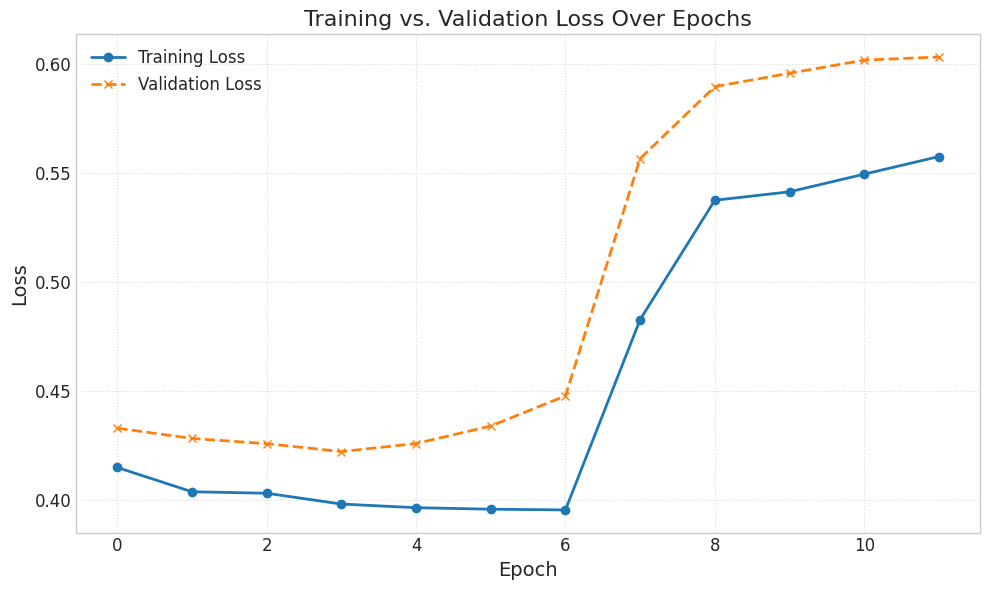

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.plot(history.epoch, history.history['loss'], label='Training Loss', marker='o', linestyle='-', linewidth=2)
plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss', marker='x', linestyle='--', linewidth=2)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training vs. Validation Loss Over Epochs", fontsize=16)
plt.legend(fontsize=12)  # Add a legend to distinguish the lines
plt.grid(True, linestyle=':', alpha=0.7)  # Add a subtle grid for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.style.use('seaborn-v0_8-whitegrid') # Use a visually appealing style (optional)
plt.show()

Vemos que los valores de loss para entrenamiento y validación empiezan siendo muy similares, lo que indica poco aprendizaje inicial (epoch 0) y terminan siendo más altos y con mayor diferencia entre uno y otro (epoch 11).

También podemos ver los valores de loss separados por cada variable.

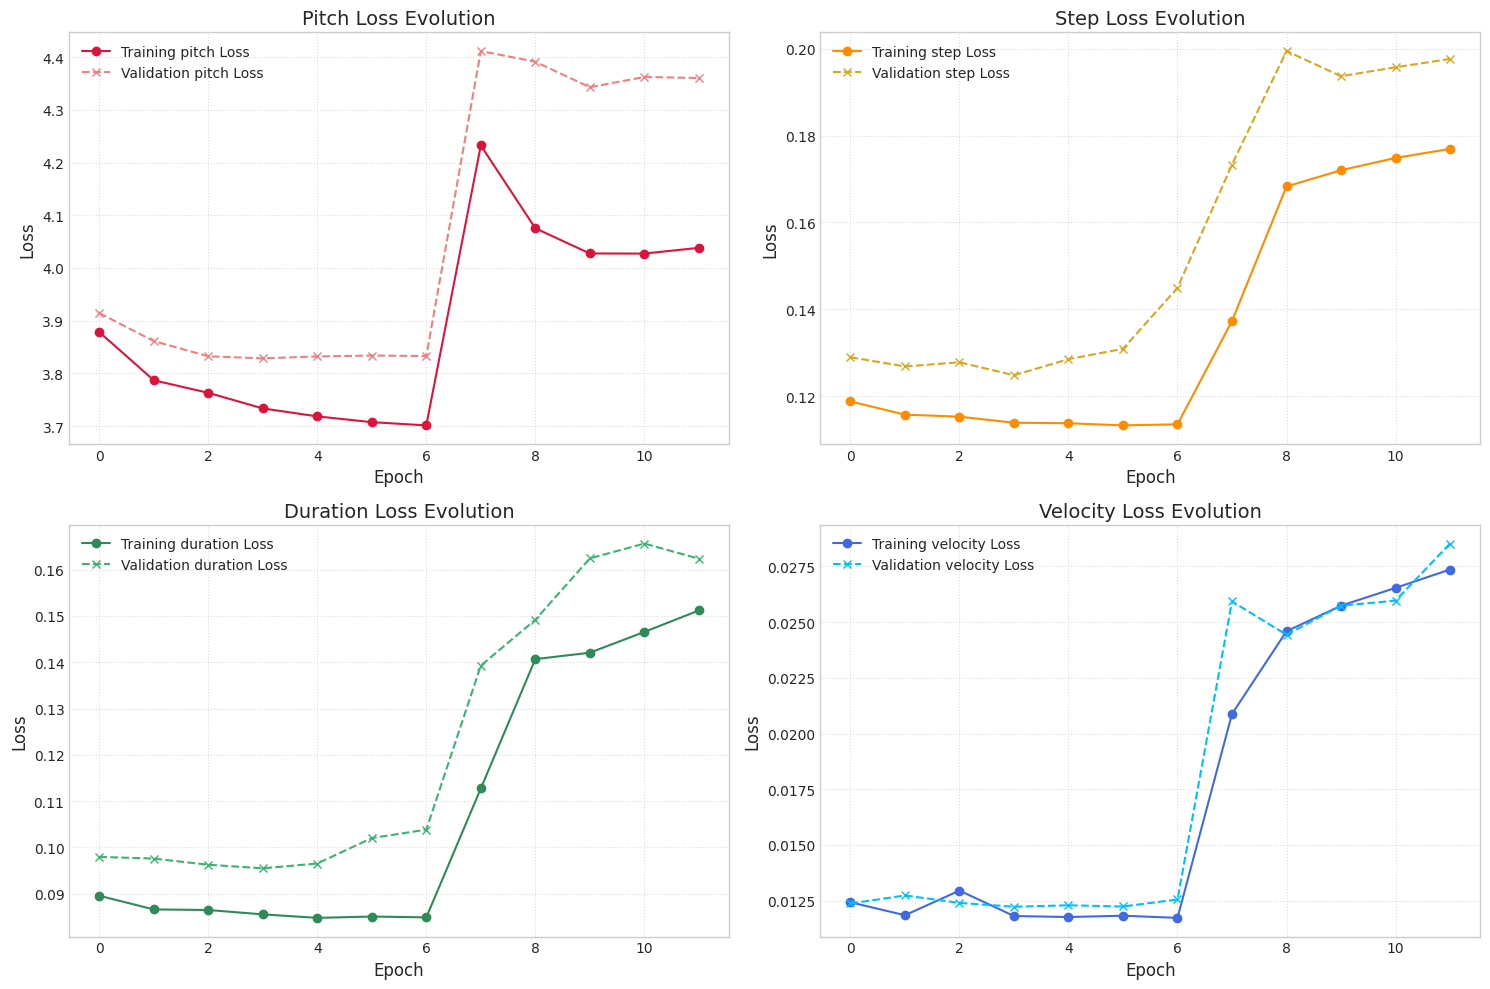

In [72]:
# Nombres de las salidas
output_names = ['pitch', 'step', 'duration', 'velocity']

# Colores distintos para cada métrica
train_colors = ['crimson', 'darkorange', 'seagreen', 'royalblue']
val_colors = ['lightcoral', 'goldenrod', 'mediumseagreen', 'deepskyblue']

plt.figure(figsize=(15, 10))
for i, name in enumerate(output_names):
    plt.subplot(2, 2, i + 1)  # Crear una cuadrícula de 2x2 subplots

    # Graficar la pérdida de entrenamiento
    plt.plot(history.epoch, history.history[f'{name}_loss'],
             label=f'Training {name} Loss',
             marker='o', linestyle='-', color=train_colors[i])

    # Graficar la pérdida de validación (si existe)
    if f'val_{name}_loss' in history.history:
        plt.plot(history.epoch, history.history[f'val_{name}_loss'],
                 label=f'Validation {name} Loss',
                 marker='x', linestyle='--', color=val_colors[i])

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(f'{name.capitalize()} Loss Evolution', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

## Evaluación sobre el conjunto de test

Evaluamos sobre el conjunto de test y obtenemos las métricas de loss.

In [61]:
test_losses = model.evaluate(test_dataset, return_dict=True)

print("Resultados de la evaluación en el conjunto de test:")
for name, value in test_losses.items():
    print(f"{name}: {value:.4f}")

5321/5321 ━━━━━━━━━━━━━━━━━━━━ 154s 29ms/step - duration_loss: 0.0802 - loss: 0.3908 - pitch_loss: 3.8270 - step_loss: 0.1075 - velocity_loss: 0.0118
Resultados de la evaluación en el conjunto de test:
duration_loss: 0.0821
loss: 0.3921
pitch_loss: 3.8189
step_loss: 0.1079
velocity_loss: 0.0119


2025-05-14 00:37:57.216753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11324895377915503646
2025-05-14 00:37:57.216891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4307415741734002070
/home/carmenfdez/MUS/melodIA/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [75]:
predictions = model.predict(test_dataset)

5321/5321 ━━━━━━━━━━━━━━━━━━━━ 143s 27ms/step


/home/carmenfdez/MUS/melodIA/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-14 00:53:30.158721: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Guardar las predicciones para cada salida en archivos .npy separados
np.save('pitch_predictions.npy', predictions['pitch'])
np.save('step_predictions.npy', predictions['step'])
np.save('duration_predictions.npy', predictions['duration'])
np.save('velocity_predictions.npy', predictions['velocity'])

print("Predicciones guardadas como archivos .npy")

In [ ]:
# Para cargar las predicciones posteriormente:
# loaded_pitch_predictions = np.load('pitch_predictions.npy')